### Dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Dense, Flatten, Add, Input,
    Conv2D, MaxPool2D, GlobalAvgPool2D,
    Concatenate
)
from tensorflow.keras.regularizers import l2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time


In order to reference the class names of the images during the visualization stage, a python list containing the classes is initialized with the variable name CLASS_NAMES.

In [ ]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Processing functions  
참고 https://sungbeomchoi.github.io/paper_implementation/2021-03-17-Resnet_Implementation

In [ ]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
BATCH_SIZE = 128

def generate_datasets():
  (train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
  test_images, test_labels = resize_and_rescale(test_images, test_labels)
  train_images, train_labels = augment(train_images, train_labels ) # data augmentation on training data

  return train_images, train_labels, test_images, test_labels

def resize_and_rescale(image, label):
  image= tf.cast(image, tf.float32)
  image = tf.image.resize(image,[IMAGE_WIDTH, IMAGE_HEIGHT])
  image  -= np.mean(image, axis=0)
  image /= np.std(image, axis=0)
  return image, label
"""
  if os.path.exists('pixel_mean_value.npy'):
    mean_image = np.load('pixel_mean_value.npy')
  else:
    mean_image = np.mean(image, axis=0)
  image -= mean_image # per-pixel mean subtraction
  image = (image / 128.0) # normalization to [-1,1] RGB images range from 0~255
  """

def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 4 pixels of padding
  image = tf.map_fn(lambda img: tf.image.resize_with_crop_or_pad(img, IMAGE_WIDTH + 4, IMAGE_HEIGHT + 4), image)
   # Random crop back to the original size
  image = tf.map_fn(lambda img: tf.image.random_crop(img, size=[IMAGE_WIDTH, IMAGE_HEIGHT, 3]), image)
  # Random horizonal flip
  image = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), image)
  return image, label


In [ ]:
train_images, train_labels, test_images, test_labels = generate_datasets()
print('train input shape: ', train_images.shape) # (50000, 32, 32, 3)
print('test input shape: ', train_labels.shape) # (10000, 32, 32, 3)
print('train output shape: ', test_images.shape) # (50000, 1)
print('train oupput shape: ', test_labels.shape) # (50000, 1)

train input shape:  (50000, 32, 32, 3)
test input shape:  (50000, 1)
train output shape:  (10000, 32, 32, 3)
train oupput shape:  (10000, 1)


[9]


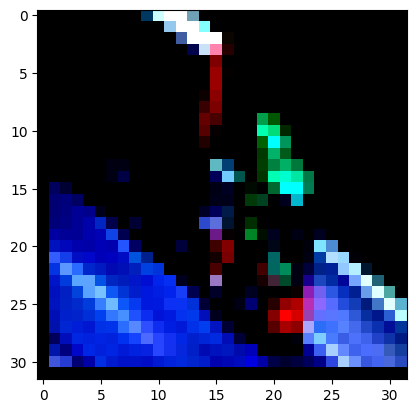

In [ ]:
# Drawing sample .
num = 50
plt.imshow(train_images[num])
print(train_labels[num])

## Defining model  
참고 https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras


In [ ]:
"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""


from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [ ]:
model = ResNet18(10)
model.build(input_shape = (None, 32,32,3))
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=False), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer = "adam",loss='sparse_categorical_crossentropy', metrics=["accuracy"])
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBloc  multiple                  74368     
 k)                                                              
                                                         

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras import regularizers


# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.1로 줄임.
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='min', verbose=1, min_lr = 0.1)
ely_cb = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

history = model.fit(train_images, train_labels, epochs=30,
                    #steps_per_epoch=int(np.ceil(tr_images.shape[0]/BATCH_SIZE)),
                    validation_split = 0.2,
					          batch_size=BATCH_SIZE,
                    #validation_steps=int(np.ceil(val_images.shape[0]/BATCH_SIZE)),
                    callbacks=[rlr_cb]
                   )

Epoch 1/30
313/313 [==============================] - 30s 40ms/step - loss: 1.6303 - accuracy: 0.4349 - val_loss: 1.3714 - val_accuracy: 0.5075 - lr: 0.0100
Epoch 2/30
313/313 [==============================] - 12s 37ms/step - loss: 1.1911 - accuracy: 0.5808 - val_loss: 1.2342 - val_accuracy: 0.5697 - lr: 0.0100
Epoch 3/30
313/313 [==============================] - 11s 36ms/step - loss: 1.0093 - accuracy: 0.6513 - val_loss: 1.1976 - val_accuracy: 0.5877 - lr: 0.0100
Epoch 4/30
313/313 [==============================] - 11s 34ms/step - loss: 0.8363 - accuracy: 0.7090 - val_loss: 1.1275 - val_accuracy: 0.6186 - lr: 0.0100
Epoch 5/30
313/313 [==============================] - 11s 34ms/step - loss: 0.6995 - accuracy: 0.7535 - val_loss: 1.0762 - val_accuracy: 0.6333 - lr: 0.0100
Epoch 6/30
313/313 [==============================] - 11s 35ms/step - loss: 0.5669 - accuracy: 0.8011 - val_loss: 1.2620 - val_accuracy: 0.6306 - lr: 0.0100
Epoch 7/30
313/313 [==============================] - 11s 

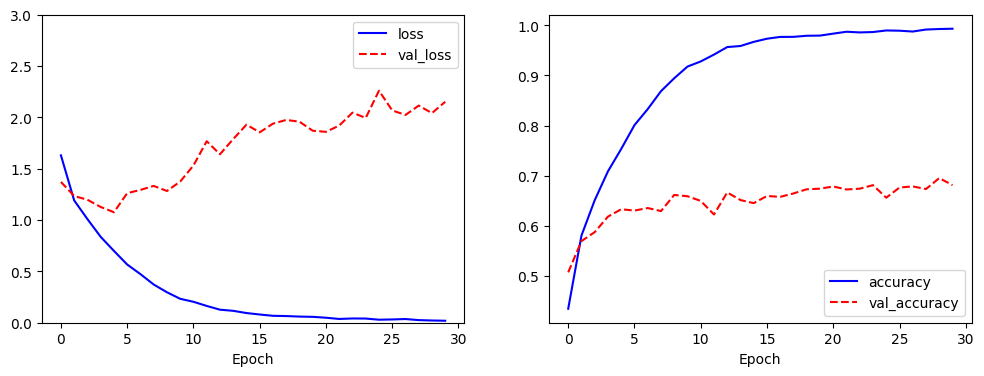

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()